In [1]:
import nltk
nltk.download("punkt");
import numpy as np
import re
import urllib

[nltk_data] Downloading package punkt to /Users/v0m01sk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
SEED = 1234


In [3]:
# Set seed for reproducibility
np.random.seed(SEED)

In [4]:
# Split text into sentences
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
book = open("datasets/harrypotter.txt",encoding='ISO-8859-1')
sentences = tokenizer.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

15640 sentences


In [5]:
def preprocess(text):
    """Conditional preprocessing on our text."""
    # Lower
    text = text.lower()

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    # Separate into word tokens
    text = text.split(" ")

    return text

In [6]:
# Preprocess sentences
print (sentences[11])
sentences = [preprocess(sentence) for sentence in sentences]
print (sentences[11])


Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


### Word2Vec

In [7]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [8]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # Ignores all words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [9]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(
    sentences=sentences, vector_size=EMBEDDING_DIM,
    window=WINDOW, min_count=MIN_COUNT,
    sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (w2v)

Word2Vec<vocab=4836, vector_size=100, alpha=0.025>


In [10]:
# Vector for each word
w2v.wv.get_vector("potter")


array([-0.12699352, -0.17945859, -0.02842927,  0.18085366,  0.39401197,
       -0.23843837,  0.10709333,  0.22894466, -0.26733428, -0.42368442,
       -0.2703049 , -0.3565948 ,  0.10423029, -0.08112939,  0.25583032,
       -0.22773156, -0.11745971, -0.08729629,  0.02723035, -0.77030116,
        0.03699608, -0.11432514, -0.04923914, -0.37714446, -0.02621232,
       -0.01370691,  0.08995658,  0.01133524, -0.08143893,  0.4417435 ,
       -0.00973469, -0.06981888,  0.11526221, -0.04953983, -0.13826434,
       -0.02830129, -0.04691692, -0.2543932 ,  0.07128965, -0.20294228,
        0.392661  , -0.40073213, -0.08232796,  0.23154454,  0.3641323 ,
       -0.13340057,  0.32479513, -0.2448636 ,  0.32145348,  0.11059126,
        0.43174803, -0.16449459,  0.4753074 , -0.2452044 , -0.19191335,
        0.09374887, -0.43624127,  0.25794244, -0.4029199 ,  0.0149832 ,
        0.19034143,  0.09080013,  0.13090806,  0.06975318, -0.34754243,
        0.556014  ,  0.38723427,  0.26847625, -0.13998124,  0.45

In [11]:

# Saving and loading
w2v.wv.save_word2vec_format("model.bin", binary=True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary=True)

### Fasttext 

In [12]:
from gensim.models import FastText

In [17]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, vector_size=EMBEDDING_DIM,
              window=WINDOW, min_count=MIN_COUNT,
              sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (ft)

FastText<vocab=4836, vector_size=100, alpha=0.025>


In [18]:
# This word doesn't exist so the word2vec model will error out
w2v.wv.most_similar(positive="scarring", topn=5)

AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [19]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

[('swimming', 0.9932186603546143),
 ('bulging', 0.9926645159721375),
 ('dabbing', 0.992368221282959),
 ('dueling', 0.9923586249351501),
 ('building', 0.9923309683799744)]

In [20]:
# Save and loading
ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

## Pretrained Embeddings

In [21]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [22]:
# Arguments
EMBEDDING_DIM = 100


In [23]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

In [25]:
# # Unzip the file (may take ~3-5 minutes)
# resp = urlopen("http://nlp.stanford.edu/data/glove.6B.zip")
# zipfile = ZipFile(BytesIO(resp.read()))
# zipfile.namelist()

In [27]:
# Write embeddings to file
embeddings_file = "glove.6B.{0}d.txt".format(EMBEDDING_DIM)
# zipfile.extract(embeddings_file)

In [28]:
# Preview of the GloVe embeddings file
with open(embeddings_file, "r") as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [29]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/3028217428.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(embeddings_file, word2vec_output_file)


(400000, 100)

In [30]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [31]:
# (king - man) + woman = ?
# king - man = ? -  woman
glove.most_similar(positive=["woman", "king"], negative=["man"], topn=5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380331993103),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [32]:
# Get nearest neighbors (excluding itself)
glove.most_similar(positive="goku", topn=5)

[('gohan', 0.7246543169021606),
 ('bulma', 0.6497019529342651),
 ('raistlin', 0.644360363483429),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [33]:
X = glove[glove.key_to_index.keys()]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

In [34]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index_to_key.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()


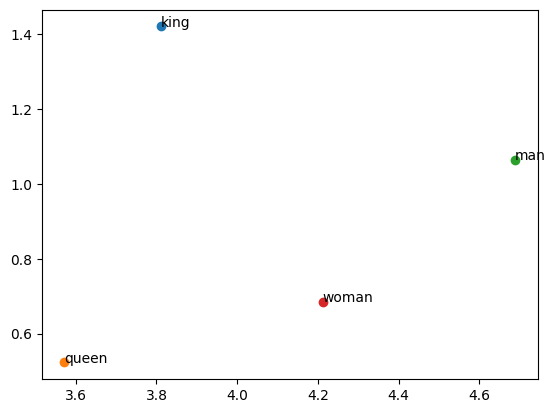

In [35]:

plot_embeddings(
    words=["king", "queen", "man", "woman"], embeddings=glove,
    pca_results=pca_results)

In [36]:
# Bias in embeddings
glove.most_similar(positive=["woman", "doctor"], negative=["man"], topn=5)

[('nurse', 0.7735227942466736),
 ('physician', 0.7189430594444275),
 ('doctors', 0.6824327707290649),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033091545105)]

### Pretrained Embeddings

In [37]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn


/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/2088852160.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [38]:
SEED = 1234


In [39]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [40]:
# Set seeds for reproducibility
set_seeds(seed=SEED)

In [41]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)


cpu


/Users/v0m01sk/Documents/1_code/personal/mlops/madewithML/foundations/made_with_ml_env/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [42]:
# Load data
url = "datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()


,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


In [43]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [44]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/v0m01sk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text


In [46]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [47]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says

sharon accepts plan reduce gaza army operation haaretz says


In [48]:
import collections
from sklearn.model_selection import train_test_split


In [49]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [50]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [51]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [52]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: china battles north korea nuclear talks → World


In [53]:
import itertools

In [54]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [55]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [56]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")


y_train[0]: World
y_train[0]: 3


In [57]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


In [58]:
import json
from collections import Counter
from more_itertools import take


In [59]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = "" if self.char_level else " "
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(" ")
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [60]:
# Tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=5000)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=5000)>


In [61]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 14


In [62]:
# Convert texts to sequences of indices
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → china battles north korea nuclear talks
  (tokenized) → [  16 1491  285  142  114   24]


### Embedding layer

In [63]:
vocab_size=10
x = torch.randint(high=vocab_size, size=(1,5))
print(x)
print(x.shape)

tensor([[5, 1, 6, 5, 6]])
torch.Size([1, 5])


In [64]:
embeddings = nn.Embedding(embedding_dim=100,
                          num_embeddings=vocab_size)
print(embeddings.weight.shape)

torch.Size([10, 100])


In [65]:
embeddings(x).shape

torch.Size([1, 5, 100])

In [66]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [67]:
# 2D sequences
padded = pad_sequences(X_train[0:3])
print (padded.shape)
print (padded)

(3, 6)
[[1.600e+01 1.491e+03 2.850e+02 1.420e+02 1.140e+02 2.400e+01]
 [1.445e+03 2.300e+01 6.560e+02 2.197e+03 1.000e+00 0.000e+00]
 [1.200e+02 1.400e+01 1.955e+03 1.005e+03 1.529e+03 4.014e+03]]


### Dataset

In [68]:
FILTER_SIZES = list(range(1, 4)) # uni, bi and tri grams


In [69]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        y = np.stack(batch[:, 1], axis=0)

        # Pad sequences
        X = pad_sequences(X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

In [70]:
# Create datasets
max_filter_size = max(FILTER_SIZES)
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=max_filter_size)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=max_filter_size)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=max_filter_size)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [  16 1491  285  142  114   24]
  y: 3


In [71]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 14]
  y: [64]
Sample point:
  X: tensor([  16, 1491,  285,  142,  114,   24,    0,    0,    0,    0,    0,    0,
           0,    0])
  y: 3


### Model

In [72]:
import math
import torch.nn.functional as F

In [73]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
DROPOUT_P = 0.1

In [75]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters,
                 filter_sizes, hidden_dim, dropout_p, num_classes,
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(CNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)

        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        # Concat conv outputs
        z = torch.cat(z, 1)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [77]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings


In [78]:
def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [81]:
# Create embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, word_index=tokenizer.token_to_index,
    embedding_dim=EMBEDDING_DIM)
print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=5000, dim=100)>


### Experiments

In [82]:
# randomly initialized embeddings (fine-tuned)
# GloVe embeddings (frozen)
# GloVe embeddings (fine-tuned

In [83]:
import json
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import Adam


In [84]:
NUM_FILTERS = 50
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 10

In [85]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [86]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

### a. Random Init

In [88]:
PRETRAINED_EMBEDDINGS = None
FREEZE_EMBEDDINGS = False


In [89]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [90]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [91]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [92]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)


In [93]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Epoch: 1 | train_loss: 0.76771, val_loss: 0.59960, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.49467, val_loss: 0.56995, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.40616, val_loss: 0.59464, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.34672, val_loss: 0.61629, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.29819, val_loss: 0.65467, lr: 1.00E-03, _patience: 2
Epoch: 6 | train_loss: 0.25764, val_loss: 0.68787, lr: 1.00E-04, _patience: 1
Stopping early!


In [94]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


In [95]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))


{
  "precision": 0.8129603024669748,
  "recall": 0.8116111111111111,
  "f1": 0.8120434581231313,
  "num_samples": 18000.0
}


### b.  Glove frozen

In [96]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = True

In [97]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [98]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [99]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [100]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)


In [101]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Epoch: 1 | train_loss: 0.51481, val_loss: 0.47758, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.44086, val_loss: 0.46504, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.41160, val_loss: 0.46613, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.38803, val_loss: 0.47267, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.36885, val_loss: 0.48240, lr: 1.00E-03, _patience: 2
Epoch: 6 | train_loss: 0.35272, val_loss: 0.49369, lr: 1.00E-04, _patience: 1
Stopping early!


In [102]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


In [103]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.832625657783757,
  "recall": 0.8326111111111111,
  "f1": 0.8324252996800303,
  "num_samples": 18000.0
}


### c.glove(fine tuned)

In [104]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = False


In [105]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [106]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [107]:

# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [108]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn,
    optimizer=optimizer, scheduler=scheduler)

In [109]:

# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


Epoch: 1 | train_loss: 0.48896, val_loss: 0.44544, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.39139, val_loss: 0.44009, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.34597, val_loss: 0.45736, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.30353, val_loss: 0.49066, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.25908, val_loss: 0.55018, lr: 1.00E-03, _patience: 2
Epoch: 6 | train_loss: 0.21547, val_loss: 0.63128, lr: 1.00E-04, _patience: 1
Stopping early!


In [110]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


In [111]:
# Determine performance
performance = get_metrics(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))


{
  "precision": 0.8278757231947823,
  "recall": 0.8276111111111111,
  "f1": 0.827694225221748,
  "num_samples": 18000.0
}


In [112]:
# Save artifacts
from pathlib import Path
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, "tokenizer.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [113]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [115]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, "tokenizer.json"))
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [116]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [117]:
# Dataloader
text = "The final tennis tournament starts next week."
X = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(X))
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler, max_filter_size=max_filter_size)
dataloader = dataset.create_dataloader(batch_size=batch_size)


['final tennis tournament starts next week']


In [118]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)


/var/folders/h4/5hv0v80j57j3rmy2pmmxvpb80000gq/T/ipykernel_1931/4106836722.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(z).cpu().numpy()


['Sports']

In [119]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))


{
  "Sports": 1.0,
  "World": 5.2038581777047455e-12,
  "Sci/Tech": 1.5110102839083206e-12,
  "Business": 1.1102017429223568e-15
}


### Interpretability

In [120]:
import collections
import seaborn as sns

In [144]:
class InterpretableCNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters,
                 filter_sizes, hidden_dim, dropout_p, num_classes,
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(InterpretableCNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)

        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            z.append(_z.cpu().numpy())

        return z

In [145]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = False


In [146]:
# Initialize model
interpretable_model = InterpretableCNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
interpretable_model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
interpretable_model.to(device)

InterpretableCNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [147]:
# Get conv outputs
interpretable_model.eval()
conv_outputs = []
with torch.inference_mode():
    for i, batch in enumerate(dataloader):

        # Forward pass w/ inputs
        inputs, targets = batch[:-1], batch[-1]
        z = interpretable_model(inputs)

        # Store conv outputs
        conv_outputs.extend(z)

conv_outputs = np.vstack(conv_outputs)
print (conv_outputs.shape)

(3, 50, 6)


In [158]:
# Visualize a bi-gram filter's outputs
tokens = tokenizer.sequences_to_texts(X)[0].split(" ")
filter_size = 2
# sns.heatmap(conv_outputs[filter_size-1][:, len(tokens)-1], xticklabels=tokens)#

In [167]:
sample_index = 0
print (f"Original text:\n{text}")
print (f"\nPreprocessed text:\n{tokenizer.sequences_to_texts(X)[0]}")
print ("\nMost important n-grams:")
# Process conv outputs for each unique filter size
for i, filter_size in enumerate(FILTER_SIZES):

    # Identify most important n-gram (excluding last token)
    popular_indices = collections.Counter([np.argmax(conv_output) \
            for conv_output in conv_outputs[i]])

    # Get corresponding text
    start = popular_indices.most_common(1)[-1][0]
    n_gram = " ".join([token for token in tokens[start:start+filter_size]])
    print (f"[{filter_size}-gram]: {n_gram}")

Original text:
The final tennis tournament starts next week.

Preprocessed text:
final tennis tournament starts next week

Most important n-grams:
[1-gram]: tennis
[2-gram]: tennis tournament
[3-gram]: final tennis tournament
